# **Paying Attention to Transformers**

<img src="https://machinelearningmastery.com/wp-content/uploads/2021/08/attention_research_1.png" width="40%" />

<a href="https://colab.research.google.com/github/deep-learning-indaba/indaba-pracs-2022/blob/prac-transformers-and-attention/attention_and_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> [THIS SHOULD STILL CHANGE TO OUR PRAC]

© Deep Learning Indaba 2022. Apache License 2.0.

**Authors:**

**Introduction:** 

The transformer architecture, introduced in Vaswani et al. 2017 .'s paper Attention is All You Need, has significantly impacted the deep learning field. It has arguably become the de-facto architecture for complex Natural Language Processing (NLP) tasks; and can outperform benchmarks in various domains, including computer vision and reinforcement learning.

Transformers, as the title of the original paper implies, are almost entirely based on a concept known as attention. Attention allows models to "focus" on different parts of an input; while considering the entire context of the input versus an RNN, that operates on the data sequentially.

In this practical, we will introduce attention in greater detail and build the entire transformer architecture block by block to see why it is such a robust and powerful architecture.

**Topics:** 

Content: <font color='blue'>`Attention mechanisms, Transformers, NLP`</font>  
Level: <font color='grey'>`Advanced`</font>


**Aims/Learning Objectives:**

- Learn how different attention mechanisms can be implemented.
- Learn and create the basic building blocks from scratch for the most common transformer architectures.
- Learn how to train a sequence-sequence model.
- Create and train a small GPT inspired model.
- Learn how to use the [Hugging Face](https://huggingface.co/) library for quicker development cycles.

**Prerequisites:**

- Basic understanding of Jax and Haiku
- Basic understanding linear algebra
- RNN based sequence-sequence models
- Word2Vec

**Outline:** 


**Before you start:**

For this practical, you will need to use a TPU to speed up training. To do this, go to the "Runtime" menu in Colab, select "Change runtime type" and then in the popup menu, choose "TPU" in the "Hardware accelerator" box.

## Installation and Imports

In [1]:
## Install and import anything required. Capture hides the output from the cell. 
#@title Install and import required packages. (Run Cell)

!pip install git+https://github.com/deepmind/dm-haiku flax optax
!pip install transformers==4.12.1 datasets 
!pip install seaborn umap-learn
!pip install livelossplot 

import os
import math
import urllib.request

# https://stackoverflow.com/questions/68340858/in-google-colab-is-there-a-programing-way-to-check-which-runtime-like-gpu-or-tpu
if int(os.environ["COLAB_GPU"]) > 0:
  print("a GPU is connected.")
elif "COLAB_TPU_ADDR" in os.environ and os.environ["COLAB_TPU_ADDR"]:
  print("A TPU is connected.")
  import jax.tools.colab_tpu
  jax.tools.colab_tpu.setup_tpu()
else:
  print("Only CPU accelerator is connected.")

import jax
import jax.numpy as jnp
from jax import grad, jit, vmap

import haiku as hk
import transformers
from transformers import pipeline, AutoTokenizer, AutoModel
import datasets

import optax

from PIL import Image
from livelossplot import PlotLosses


import torch
import torchvision

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import itertools
import random

# download images used in notebook
urllib.request.urlretrieve(
  'https://images.unsplash.com/photo-1529778873920-4da4926a72c2?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxzZWFyY2h8MXx8Y3V0ZSUyMGNhdHxlbnwwfHwwfHw%3D&w=1000&q=80',
   "cat.png")


import gensim
from nltk.data import find
import nltk
nltk.download('word2vec_sample')


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/deepmind/dm-haiku to /tmp/pip-req-build-85fg5q9f
  Running command git clone -q https://github.com/deepmind/dm-haiku /tmp/pip-req-build-85fg5q9f
     |████████████████████████████████| 202 kB 30.3 MB/s 
     |████████████████████████████████| 145 kB 68.6 MB/s 
     |████████████████████████████████| 217 kB 15.2 MB/s 
     |████████████████████████████████| 596 kB 6.7 MB/s 
     |████████████████████████████████| 9.1 MB 31.1 MB/s 
     |████████████████████████████████| 51 kB 8.5 MB/s 
     |████████████████████████████████| 72 kB 794 kB/s 
  Created wheel for dm-haiku: filename=dm_haiku-0.0.8.dev0-py3-none-any.whl size=605538 sha256=d5e47c12d40eeaf3a54db1d8531ff8b9e3cbf6b6bc55e7f4d21c601030ef8784
  Stored in directory: /tmp/pip-ephem-wheel-cache-6f7jqolm/wheels/06/28/69/ebaac5b2435641427299f29d88d005fb4e2627f4a108f0bdbc
Successfully built dm-haiku
  Attempting

a GPU is connected.


[nltk_data] Downloading package word2vec_sample to /root/nltk_data...
[nltk_data]   Unzipping models/word2vec_sample.zip.


True

In [2]:
#@title Helper Functions. (Run Cell)

def plot_position_encodings(P, max_tokens, d_model):
  plt.figure(figsize=(20,np.min([8,max_tokens])))
  im = plt.imshow(P, aspect="auto", cmap='Blues_r')
  plt.colorbar(im, cmap='blue')

  if d_model<=64:
    plt.xticks(range(d_model))
  if max_tokens <=32:
    plt.yticks(range(max_tokens))
  plt.xlabel('Embedding index')
  plt.ylabel('Position index')
  plt.show()


def plot_image_patches(patches):
  axes=[]
  fig=plt.figure(figsize=(25,25))
  for a in range(patches.shape[1]):
      axes.append(fig.add_subplot(1, patches.shape[1], a+1) ) 
      plt.imshow(patches[0][a])
  fig.tight_layout()    
  plt.show()


def plot_projected_embeddings(embeddings, labels):
  import umap
  import seaborn as sns

  projected_embeddings = umap.UMAP().fit_transform(embeddings)

  plt.figure(figsize=(15,8))
  plt.title('Projected text embeddings')
  sns.scatterplot(
      x=projected_embeddings[:,0],
      y=projected_embeddings[:,1],
      hue=labels
  )
  plt.show()


def get_word2vec_embedding(words):
  word2vec_sample = str(find('models/word2vec_sample/pruned.word2vec.txt'))
  model = gensim.models.KeyedVectors.load_word2vec_format(
      word2vec_sample, 
      binary=False
  )
  
  output = []
  words_pass = []
  for word in words:
    try:
      output.append(jnp.array(model.word_vec(word)))
      words_pass.append(word)
    except:
      pass

  embeddings = jnp.array(output)
  del model # free up space again
  return embeddings,words_pass 

def plot_attention_weight_matrix(weight_matrix, x_ticks, y_ticks):
  plt.figure(figsize=(15,7))
  ax = sns.heatmap(weight_matrix, cmap='Blues')
  plt.xticks(np.arange(weight_matrix.shape[1])+0.5, x_ticks)
  plt.yticks(np.arange(weight_matrix.shape[0])+0.5, y_ticks)
  plt.title('Attention matrix')
  plt.xlabel('Attend score')
  plt.show()


def remove_punctuation(text):
  import re
  text = re.sub(r'[^\w\s]', '', text)

  return text




In [3]:
#@title Check what device you are using (Run Cell)
print(f"Num devices: {jax.device_count()}")
print(f" Devices: {jax.devices()}")

INFO:absl:Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
INFO:absl:Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter CUDA Host
INFO:absl:Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'


Num devices: 1
 Devices: [GpuDevice(id=0, process_index=0)]


## **Attention**

In order to understand the transformer architecture, one must understand the concept of attention and how it is implemented from a deep learning sense. The attention mechanism is based on how humans would interpret an image or read a sentence. 

Let us take the image of the dog in human clothes below (image and example [source](https://lilianweng.github.io/posts/2018-06-24-attention/)). When paying *attention* to the red blocks of pixels, we will say that the yellow block of pointy ears is something we expected (correlated) but that the grey blocks of human clothes are unexpected for us (uncorrelated), *based on what we have seen in the past*. 

<img src="https://drive.google.com/uc?export=view&id=1iEU7Cph2D2PCXp3YEHj30-EndhHAeB5T" alt="drawing" width="450"/>

When we look at the red pixels, we tend to start paying *attention* to relevant pixels or *attend* to these pixels, almost fading out the snow in the background and human clothes. However, when we start looking at the background, we will fade out the dog pixels, as it does not contribute to the current task at hand

The same thing happens when we read. In order to understand the entire sentence, we will learn to correlate and *attend to* certain words based on the context of the entire sentence. For instance, in the first sentence below, when looking at the word "coding", we pay more attention to the word "Apple" and "computer" because we know that when we speak about coding, "Apple" is actually referring to the company. 

However, in the second sentence, we realise we should not consider " apple " when looking at "code" because given the context of the rest of the sentence, we know that this apple is referring to an actual apple and not a computer.


<img src="https://drive.google.com/uc?export=view&id=1j23kcfu_c3wINU6DUvxzMYNmp4alhHc9" alt="drawing" width="350"/>

In the following sections, we will dive deeper into the mechanisms that allow us to train our deep learning models to attend to input data, given the context of other input data.

### Sequence to sequence attenion mechanisms - <font color='blue'>`Intermediate`</font>




The first attention mechanisms were born for sequence-2-sequence models. These models were usually RNN encoder and decoder structures. The input sequence was processed sequentially by an RNN, encoding the sequence to a single context vector, which is then fed into another RNN that generates a new sequence. Below is an example of this ([source](https://lilianweng.github.io/posts/2018-06-24-attention/)).


<img src="https://drive.google.com/uc?export=view&id=1FKfaArN1rsLjzVWaJGpMLEcxEshSLXd6" alt="drawing" width="600"/>

Due to their only being one context vector, it was often found that for longer input sequences, information gets lost due to the inability of the encoders to remember longer sequences. The attention mechanism introduced in [Bahdanau et al., 2015](https://arxiv.org/pdf/1409.0473.pdf) was proposed to solve this.


Here, instead of relying on one static context vector, which is also only used once in the decoding process, let us provide information on the entire input sequence at every decoding step using a dynamic context vector. By doing this, the decoder can access a larger "bank" of memory and attend to the input's required information based on the output's current state. This is shown below.

<img src="https://drive.google.com/uc?export=view&id=1fB5KObXcKo5x35xlIDIcjHTq1q75ejIB" alt="drawing" width="600"/>




Using an attention mechanism, we can then attend to each input hidden state. This mechanism, usually, consists of two steps for each decoding step $t$: 

1. Calculate the score (importance) for each $h_n$, given $s_{t-1}$ and generate and attention weight, $w_{n}$. 
  - $\text{score} = a(s_{t−1}, h_{n})$, where $a$ can be any differentiable function
  - $w_{n} = \frac{\exp \left\{a\left(s_{t-1}, h_{n}\right)\right\}}{\sum_{j=1}^{N} \exp \left\{a\left(s_{t-1}, h_{j}\right)\right\}}$
2. Generate the final context vector, $c_t$
  - $c_t=\sum_{n=1}^{N} w_n h_{n}$  

The final state fed into the RNN to generate $s_{t+1}$, is given below, where $f$ can again be any combination method. 

$s_{t+1} = f\left ( c_t, s_t \right)$ 

In Bahdanau et al., 2015, $f$ was a learned feedforward layer taking in the concatenated vector $[c_t; s_t]$, with $a(s_{t−1}, h_{n})$ being the dot product. Next, let us build up this attention schema.

In dot product attention, the score is given by

$a=s_{t_1}^\top h_n$

**Code task**: Complet the dot product atttention function below.

In [ ]:
def dot_product_attention(hidden_states, previous_state):
  scores = # FINISH ME 
  w_n = # FINSIH ME 
  c_t = jnp.matmul(w_n, hidden_states)

  return w_n, c_t

In [4]:
# @title Answer to code task (Try not to peek until you've given it a good try!') 
def dot_product_attention(hidden_states, previous_state):

  scores = jnp.dot(hidden_states, previous_state.T)
  w_n = jax.nn.softmax(scores)
  c_t = jnp.matmul(w_n, hidden_states)

  return w_n, c_t

In order to show how the dot product can produce attention weights that make sense, let us use pretrained [word2vec](https://jalammar.github.io/illustrated-word2vec/) embeddings. These word2vec embeddings are generated by an encoder network that was trained to generate similar embeddings for similar meaning words. 

Even though we are not processing something sequentially now that needs context, the attention matrix should still give us something that makes sense.


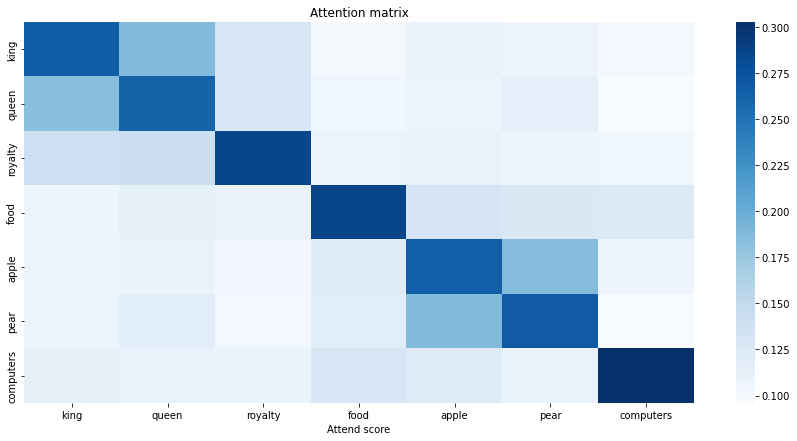

In [5]:
words = ['king', 'queen', 'royalty', 'food', 'apple', 'pear', 'computers']
word_embeddings, words = get_word2vec_embedding(words)
weights, _ = dot_product_attention(word_embeddings, word_embeddings)
plot_attention_weight_matrix(weights, words, words)

Looking at the matrix, assuming the function was implemented correctly, one will see that everything makes sense. The "royal" group of words all attend more to each other than the "food" words, which all attend to one another. We also see that "computers" have very low attend scores for all of them. 

**Group task:** 
  - Play with the word selections above. See if you can find word combinations that do not make sense. 
  - Ask your friend if they found examples.

For a more extensive range of attention mechanisms, you can visit this [link](https://lilianweng.github.io/posts/2018-06-24-attention/#summary).

### Self-attention to Multihead Attention- <font color='blue'>`Intermediate`</font>



Self-attention and multi-head attention (MHA) are the core building blocks for the transformer architecture. We will build up the intuition and implementation here in detail. Then in the **Transformers** section, you will see how this mechanism is utilised to build an attention only sequence-to-sequence model.


Going forward in this section, we will represent a sentence by splitting it up into a list of words, then using the word2vec model from above to encode each word. In the transformers section, we will dive deeper into how we transform an input into a sequence of vectors.

In [6]:
def embedd_sentence(sentence):
  # this is just for examples, later we will not do this
  sentence = remove_punctuation(sentence)
  words = sentence.split()
  sentence_vector_sequence, words = get_word2vec_embedding(words)
  return sentence_vector_sequence, words

#### Self-attention

Self-attention is an attention mechanism where we attend each vector of a given input sequence to the entire sequence. To gain an intuition for why self-attention is important, let us think about the sentence (example taken from [source](https://jalammar.github.io/illustrated-transformer/)):

`"The animal didn't cross the street because it was too tired."`

A simple question about this sentence is what the word "it" refers to? Even though it might look simple, it can be tough for an algorithm to learn this. This is where self-attention comes in, as it can learn an attention matrix for the word "it" where a large weight is assigned to the word "animal".

Self-attention also allows the model to learn how to interpret words with the same embeddings, such as apple, which can be a company or food, depending on the context. This is very similar to the hidden state found within an RNN, but this process, as you will see, allows the model to attend over the entire sequence in parrel, allowing longer sequences to be utilised. 

Self-attention consists of three concepts:

- Queries, keys and values
- Scaled dot product attention
- Masks

##### **Queries, keys and values**

Typically all attention mechanisms can be written in terms of `key-value` pairs and `queries` to calculate the attention matrix and new context vector. 

To gain intuition, one can interpret the `query` vector as containing the information we are interested in, which is used to determine the `values` we should attend to, based on the similarity between the `keys` (which are paired with the `values`) and the `query`. Thus the similarity between the `queries` and `keys` gives us our attention score, where that score then determines the attention put in conjunction with the `values`. Or as [Lena-Voita](https://lena-voita.github.io/nlp_course/seq2seq_and_attention.html) put it:

- Querie: asking for information
- Key: saying that it has some information
- Value: giving the information

In transformer architectures, we use learnable weights matrices, reprsented as $Q,K,V$, to project each sequence vector to a unique $q,k,v$ vector. 

<img src="https://drive.google.com/uc?export=view&id=1-96YjPxhcqW6FczUYwErGXHp6YpoLltq" alt="drawing" width="600"/>

You will notice that the vectors $q,k,v$ vectors are smaller in size than the input vectors. This will be covered at a later stage, but just know that it is a design choice for transformers and not required at all to work.

This process can also be parrelised, as the input sequence can be represented as a matrix $X$, and then:

$Q=W_QX \\ K=W_KX \\ V=W_VX$

**Code Task**: Code up a Haiku module that creates three linear layers such that an input can be projected down to $Q,K,V$. Hint: `hk.Linear`

In [ ]:
class SequenceToQKV(hk.Module):

  def __init__(self, output_size):
  
    super().__init__()

    self.output_size = output_size

  def __call__(self, X):

    initializer = hk.initializers.VarianceScaling(0.5)
    
    # this can also be one layer, how do you think you would do it?
    q_layer = # FINISH ME
    k_layer = # FINISH ME
    v_layer = # FINISH ME

    Q = q_layer(X)
    K = k_layer(X)
    V = v_layer(X)

    return Q, K, V

In [7]:
# @title Answer to code task (Try not to peek until you've given it a good try!') 

class SequenceToQKV(hk.Module):

  def __init__(self, output_size):
    super().__init__()

    self.output_size = output_size

  def __call__(self, X):
    initializer = hk.initializers.VarianceScaling(0.5)
    
    # this can also be one layer, how do you think you would do it?
    q_layer = hk.Linear(self.output_size, w_init=initializer)
    k_layer = hk.Linear(self.output_size, w_init=initializer)
    v_layer = hk.Linear(self.output_size, w_init=initializer)

    Q = q_layer(X)
    K = k_layer(X)
    V = v_layer(X)

    return Q, K, V

In [ ]:
# run this to test if your code is running
def x_to_qkv(sequences):
  qkv_transforms = SequenceToQKV(64)
  return qkv_transforms(sequences)

x_to_qkv = hk.transform(x_to_qkv)

# initialise model
key = jax.random.PRNGKey(42)
x = jax.random.normal(key, [6, 53, 768])
params = x_to_qkv.init(key, x)
Q,K,V = x_to_qkv.apply(params, key, x)

##### **Scaled dot product attention**


Now that we have our `query`, `key` and `value` matrices, it is time to calculate the attention matrix. Remember, in attention mechanisms; we must first find a score for each sequence vector and then use these scores to create a new context vector. We do this in self-attention using scaled dot product attention with the formula below. 

$\operatorname{Attention}(Q, K, V)=\operatorname{softmax}\left(\frac{Q K^{T}}{\sqrt{d_{k}}}\right) V$

What happens here is similar to what we did in the dot product attention in the previous section, just applying the mechanism to the sequence itself. For each element in the sequence, we calculate the attention weight matrix between $q_i$ and $K$. $V$ is multiplied by each weight, and all weighted vectors $v_{weighted}$ are summed together to form a new representation for $q_i$. By doing this, we are essentially drowning out irrelevant vectors and bringing up important vectors in the sequence when our focus is on $q_1$.

$QK^\top$ is scaled by the square root of the dimension of the vectors, $\sqrt{d_k}$, to ensure more stable gradients during training. 


**Code Task:** Code up the scaled dot product attention function. This does not have to be a Haiku module as we are just doing matrix multiplications.

In [ ]:
# we need to code up from scratch the function
def scaled_dot_product_attention(query, key, value):
  d_k = query.shape[-1]
  logits = # FINSIH ME
  scaled_logits = # FINISH ME
  attention_weights = jax.nn.softmax(scaled_logits, axis=-1) 
  value = jnp.matmul(attention_weights, value)
  return value, attention_weights

In [8]:
# @title Answer to code task (Try not to peek until you've given it a good try!') 

def scaled_dot_product_attention(query, key, value):
  d_k = query.shape[-1]
  logits = jnp.matmul(query, jnp.swapaxes(key, -2, -1))
  scaled_logits = logits/jnp.sqrt(d_k)
  attention_weights = jax.nn.softmax(scaled_logits, axis=-1) 
  value = jnp.matmul(attention_weights, value)
  return value, attention_weights

Let's now see scaled dot product attention in action. We will take a sentence, embed each word using word2vec, and see what the final self-attention weights look like.

We will not use the linear projection layers as they are not trained. Instead, we are going to make $X=Q=V=K$.

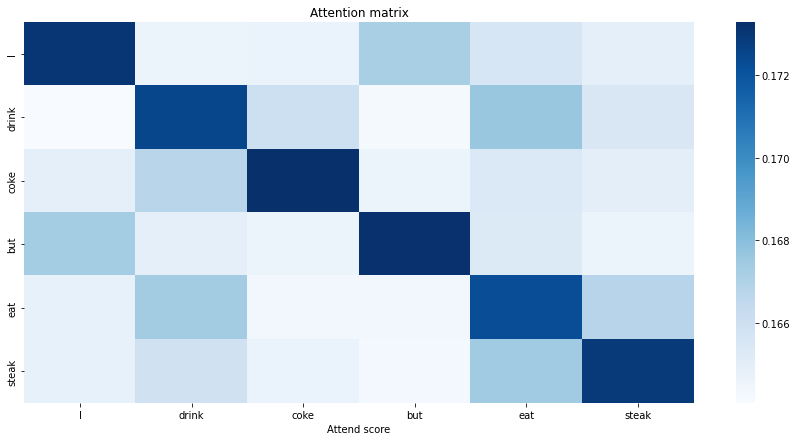

In [9]:
sentence = "I drink coke, but eat steak"
word_embeddings, words = embedd_sentence(sentence)
Q = K = V = word_embeddings

# calculate weights and plot 
values, attention_weights = scaled_dot_product_attention(Q, K, V)
words = remove_punctuation(sentence).split()
plot_attention_weight_matrix(attention_weights, words, words)

Keep in mind that we have not trained our attention matrix yet. However, we can see that by utilising the word2vec vectors as our sequence, we can see how scaled dot product attention already is capable of attending to "eat" when "steak" is our query and that the query "drink" attends more to "coke" and "eat". 

**Group task:** See if you can find any interesting results using the above, untrained, attention weights.

##### **Masked attention** 




There exist cases where applying self-attention over the entire sequence is either not feasible or not allowed even. These can include:

- Uneven length sequences batched together.
  - When sending a batch of sequences through a network, the self-attention expects each sequence to be the same length. One handles this by padding the sequence. When calculating attention, ideally, these padding vectors should not be taken into consideration
- Training a decoding model.
  - When training decoder models, such as GPT-3, the decoder has access to the entire target sequence when training (as training is done in parallel), so we have to mask the future sequence data such that earlier data can not attend to it.

By applying a mask to the final score calculated between queries and keys, we mitigate the influence of the unwanted sequence vectors. The vectors are masked by making the score between the query and their respective keys a VERY large negative value. The softmax function will push the attention weight down to zero, and the resulting value will be summed out and not influence the final representation.


Putting everything together, masked scalled dot product attention visually looks like this:

<img src="https://windmissing.github.io/NLP-important-papers/AIAYN/assets/5.png" alt="drawing" width="200"/>. 


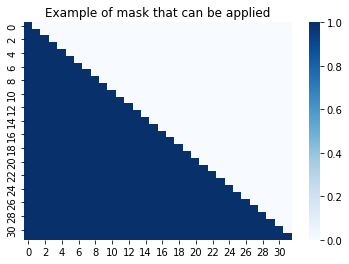

In [10]:
# example of building a mask for tokens of size 32
mask = jnp.tril(jnp.ones((32, 32)))
sns.heatmap(mask, cmap='Blues')
plt.title("Example of mask that can be applied");

**Code Task:** Try and implement the masking operation for your SCD function.

In [ ]:
# Code to be implemented during practical
def scaled_dot_product_attention(query, key, value, mask=None):
  d_k = query.shape[-1]
  T = query.shape[1]
  logits = jnp.matmul(query, jnp.swapaxes(key, -2, -1))

  if mask is not None:
    logits = # FINISH ME

  scaled_logits = logits/jnp.sqrt(d_k)
  attention_weights = jax.nn.softmax(scaled_logits, axis=-1) 
  attention = jnp.matmul(attention_weights, value)
  return attention, attention_weights

In [9]:
# @title Answer to code task (Try not to peek until you've given it a good try!'). This answer will be based on our previous answer.
def scaled_dot_product_attention(query, key, value, mask=None):
  d_k = key.shape[-1]
  T = key.shape[-2]
  logits = jnp.matmul(query, jnp.swapaxes(key, -2, -1))
  scaled_logits = logits/jnp.sqrt(d_k)

  if mask is not None:
    scaled_logits = jnp.where(
        mask[:T,:T], 
        scaled_logits, 
        -jnp.inf
    )  
  attention_weights = jax.nn.softmax(scaled_logits, axis=-1) 
  attention = jnp.matmul(attention_weights, value)
  return attention, attention_weights

In order to test if this works, lets apply a masked attention to our sequence, as one would do in a autoregressive setting, where the current output is only allowed to see the current and previous outputs.

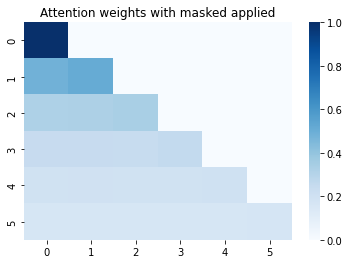

In [12]:
word_embeddings = jnp.expand_dims(word_embeddings,axis=0) if len(word_embeddings.shape)<3 else word_embeddings
mask = jnp.tril(np.ones((word_embeddings.shape[1], word_embeddings.shape[1])))

attention, attention_weights = scaled_dot_product_attention(
    word_embeddings,
    word_embeddings,
    word_embeddings,
    mask
)

plt.title('Attention weights with masked applied')
sns.heatmap(attention_weights[0], cmap='Blues');

#### Multihead Attention - <font color='blue'>`Advanced`</font>

Rather than only computing the attention once, the multi-head attention(MHA)mechanism runs through the scaled dot-product attention multiple times in parallel. According to the paper, Attention is all you need, "multi-head attention allows the model to jointly attend to information from different representation subspaces at different positions. With a single attention head, averaging inhibits this". 

This can be viewed as a similar strategy to stacking convolution kernels in a CNN layer. This allows the kernels to focus on and learn different features and rules, which can be why multiple heads of attention also work. The process for MHA is given below.

<img src="https://drive.google.com/uc?export=view&id=1q0Oq6IVEkkMfVSpY4LkHBP866mcoIFsh" alt="drawing" width="1000"/>

As can be seen from the figure, the scaled dot product attention discussed earlier is just repeated $N$ times, whith $3N$ learnable matrices for each head. The outputs from the different heads are then concataneted, whereafter it is fed through a linear projection, which is then the final produced representations. 

Due to these large amount of computations and memory requirements, a design choice made that the $W_{Qn}, W_{Kn}, W_{Vn}$ matrices produce embedding of length $d_m/N$, where $d_m$ is the input sequence embedding size and $N$ is the number heads. By doing this, the MHA function is computational wise the same as one single head of attention.

**Code Task:** Code up a Haiku module that implements the entire multi-head attention mechanism. 


In [ ]:
class MultiHeadAttention(hk.Module):

  def __init__(
      self,
      num_heads,
      d_m,
      name = None,
  ):
    super().__init__(name=name)
    self.num_heads = num_heads 

    # module to take X to Q, K, V
    self.sequence_to_qkv = SequenceToQKV(d_m)

  def __call__(self, X=None, Q=None, K=None, V=None, mask = None, return_weights=False):
    
    if None in [Q, K, V]:
      assert not X is None, 'X has to be provided if either Q,K,V not provided'
  
      # project all data to Q, K, V
      Q,K,V = # FINISHE ME

    # get the batch size, sequence lenght and embedding size
    B, T, d_m = Q.shape
    
    # calculate heads embedding size (d_m/N)
    head_size = d_m // self.num_heads

    # B,T,d_m -> B, T, N, dm//N -> B, N, T, dm//N
    q_heads = # FINISH ME
    k_heads = # FINISH ME
    v_heads = # FINISH ME

    attention, attention_weights = scaled_dot_product_attention(q_heads,k_heads,v_heads,mask)

    # (B, nh, T, hs) -> (B, T, nh, hs) -> (B, T, E) - re-assemble all head outputs
    attention = # FINISH ME

    # apply Wo
    initializer = hk.initializers.VarianceScaling(0.5)
    Wo = # FINISH ME
    X_new = Wo(attention)

    # we will use this later to plot all data
    if return_weights:
      return X_new, attention_weights 
    else:
      return X_new

In [10]:
# @title Answer to code task (Try not to peek until you've given it a good try!'). This answer will be based on our previous answer.
class MultiHeadAttention(hk.Module):

  def __init__(
      self,
      num_heads,
      d_m,
      name = None,
  ):
    super().__init__(name=name)
    self.num_heads = num_heads 
    self.sequence_to_qkv = SequenceToQKV(d_m)

  def __call__(self, X=None, Q=None, K=None, V=None, mask = None, return_weights=False):
    
    if None in [Q, K, V]:
      assert not X is None, 'X has to be provided if either Q,K,V not provided'
  
      # project all data to Q, K, V
      Q,K,V = self.sequence_to_qkv(X)

    # get the batch size, sequence lenght and embedding size
    B, T, d_m = Q.shape

    # calculate heads embedding size (d_m/N)
    head_size = d_m // self.num_heads

    # B,T,d_m -> B, T, N, dm//N -> B, N, T, dm//N
    q_heads = Q.reshape(B, T, self.num_heads, head_size).swapaxes(1,2)
    k_heads = K.reshape(B, T, self.num_heads, head_size).swapaxes(1,2)
    v_heads = V.reshape(B, T, self.num_heads, head_size).swapaxes(1,2)
    
    attention, attention_weights = scaled_dot_product_attention(q_heads,k_heads,v_heads,mask)

    # (B, nh, T, hs) -> (B, T, nh, hs) -> (B, T, E) - re-assemble all head outputs
    attention = attention.swapaxes(1,2).reshape(B, T, d_m)

    # apply Wo
    initializer = hk.initializers.VarianceScaling(0.5)
    Wo = hk.Linear(d_m, w_init=initializer)
    X_new = Wo(attention)

    if return_weights:
      return X_new, attention_weights 
    else:
      return X_new


In [ ]:
B, T, d_m, N = 5, 5, 768, 8

# run this to test if your code is running
def mha(sequences, N, d_m):
  mha = MultiHeadAttention(N, d_m)
  return mha(X=X)

mha = hk.transform(mha)

# initialise module
key = jax.random.PRNGKey(42)
X = jax.random.normal(key, [B, T,d_m])
print('BEFORE SHAPE:')
print(X.shape)
params = mha.init(key, X, N, d_m)
new_x = mha.apply(params, key, X, N, d_m)
print('AFTER SHAPE:')
print(new_x.shape)

Now that we have an understanding for how the MHA works, lets see how the transformer architecture uses them.

### Section Quiz 

[Test knowledge on all the previous material of attention]

In [ ]:
#@title Generate Quiz Form. (Run Cell)
from IPython.display import HTML
HTML(
"""
<iframe 
	src="https://forms.gle/zbJoTSz3nfYq1VrY6",
  width="80%" 
	height="1200px" >
	Loading...
</iframe>
"""
)

## **Transformers**


The Transformer architecture was proposed in the [Attention is all you need](https://arxiv.org/abs/1706.03762) paper in 2017 as a SotA model for translation. This architecture is based only on attention mechanisms, while at the time, most models would also rely on recurrences (RNNs) or convolutions.

Over time this became one of the most established and influential architectures used by the deep learning community; for example, Transformers are the base of the BERT and GPT-3 models. The architecture is also very versitale as it is capable of being used in multiple domains, including computer vision, audio processing and reinforcement learning and multimodal systems. 

In this section, we'll implement a Transformer based architecture in Haiku for a simpler task than translation: inverting a sentence. Each block will be built up from scratch and will be able to do more complex tasks. 

In this part of the tutorial we'll implement a Transformer based architecture in Haiku for a simpler task then translation: inverting a sentence.

<img src="https://media.geeksforgeeks.org/wp-content/cdn-uploads/reverse-Words.jpg" width="250"/>

We base a lot of code here from the [Deepmind Haiku example](https://github.com/deepmind/dm-haiku/tree/main/examples/transformer).

### High level overview

Originally the transformer was designed for machine translation, hence the encoder-decoder structure seen below. 

The encoder will receive an input sentence in one language and process it through multiple stacked `encoder blocks`. This creates a final representation where helpful information necessary for the decoding task has been extracted. This output is then fed into the stacked `decoder blocks` that produce new outputs in an autoregressive manner. 

<img src="https://machinelearningmastery.com/wp-content/uploads/2021/08/attention_research_1.png" width="350" />


The encoder consists of $N$ identical blocks, which process a sequence of token vectors sequentially. These blocks consist of 3 parts:

1. Multihead attention blocks. These are the transformer architecture's backbone. They process the data to generate strong vectors for each token, ensuring that the necessary information for the task at hand is represented in the vectors. These are exactly the MHA we covered in the attention section previously. 
2. An MLP is applied to each input token separately and identically.
3. Residual connection that adds the input tokens to the attended representations and a residual connection between the input to the MLP and its outputs. For both these connections, the result is normalized using layernorm. In certain implementations, these normalization steps are applied to the inputs rather than the outputs. Just like a Resnet, transformers are designed to be very deep models thus, these add and norm blocks are essential for a smooth gradient flow.  

The decoder block consists of the same parts, except for one extra MHA block that appears after the initial MHA block. This block receives the output of the final encoder block, the transformed tokens, and uses that as the query, while using the output of the first MHA block as the keys and values. In doing this, the model attends over the input required to perform the sequence task. The initial MHA block is also masked in a decoder to block future inputs when making predictions. 

This entire architecture can then be trained end to end. These models expect data to be broken up into a sequence of vectors to be processed. Next, we will deep dive into how this is done.


### Tokenisation

Before data can be fed into transformers, it has to be transformed into an acceptable format: a sequence of tokens and a vector representing each token. Below, we briefly discuss how we can transform text and vision data into tokens that transformers can process [source](https://huggingface.co/docs/transformers/preprocessing).

##### **Text**


Transformers can not handle raw strings of text. So to process text, the text is first split up into tokens, where after these tokens are indexed and each token is assigned an embedding of size $d_{model}$. These embeddings can be learned during training or can come from a pretrained vocablay of embeddings. This new sequence of token embeddings is then fed into the transformer architecture. This idea is visualised below. 

\\

<img src="https://drive.google.com/uc?export=view&id=16euh4LADP_mcXywFwKKY3QQQkVplepiI" alt="drawing" width="450"/>


These token IDs are typically predicted when a model generates text, fills in missing words, etc.

This process of splitting up text into tokens and assigning an ID to each token is called [tokenisation](https://huggingface.co/docs/transformers/tokenizer_summary). There are various ways to tokenise text, with some methods being trained directly from the data. When using pre-trained transformers, it is crucial to use the same tokeniser that was used to train the model. The previous link has in-depth descriptions of many widely known techniques.

Below we show how the [Bert](https://arxiv.org/abs/1810.04805) models tokeniser tokenises a sentence. We use [Hugging Face](https://huggingface.co/) for this part, where we have a deep dive into Hugging Face later in this notebook.

In [ ]:
bert_tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
encoded_input = bert_tokenizer("The practical is so much fun")
print(f"Token IDs: {encoded_input['input_ids']}")

Here we can see that the tokeniser returns the IDs for each token, as shown in the figure. But counting the number of IDs, we see that it is larger than the number of words in the sentence. Let's print the tokens associated with each ID.


In [ ]:
print(f"Tokens: {bert_tokenizer.decode(encoded_input['input_ids'])}")

We can see the tokeniser attaches new tokens, `[CLS]` and `[SEP]`, to the start and end of the sequence. This is a Bert specific requirement for training and inference. Adding special tokens is a very common thing to do. 

For instance, to pretrain specific transformers, they perform what is known as masked prediction. For this, random tokens in a sequence are replaced by the `[MASK]` token, and the model is trained to predict the correct token ID for the token replaced with that token. 

**Group task**:

- Discuss with a friend what you think the current issue is when feeding these raw tokens into a transformer architecture? Think about the difference in meaning between a sentence and that same sentence where the word orders are random.
- How would you fix that issue? 

##### **Images** (optional)

As mentioned, transformers are versatile and can be applied to roughly any data which can be converted into a sequence of tokens.

For example, to use the transformers encoder architecture with images, one can split an image into different patches, flatten these image patches and project each image patch into a fixed-sized embedding using any projection method. By doing this, the image has been converted into a sequence of image tokens, and the transformer will be able to process the data. 

This process is shown in the image below. 

\\

<img src="https://drive.google.com/uc?export=view&id=1ERF0f3Y_0wNb4kQ07xMYUysqNYIPkQMD" alt="drawing" width="650"/>


**Code task (OPTIONAL and ADVANCED):** Write a function that can take in a batch of images with shape (Batch, Height, Widht, Channels) and divide it into equal-sized patches. You can use the output of `image_to_patch` and `plot_image_patches` functions to visualise and test your function.

In [ ]:
def image_to_patch(image, patch_size):
    """
    Inputs:
        x - array of shape [B, H, W, C]
        patch_size - Number of pixels per dimension of the patches (integer)
    """
    B, H, W, C = image.shape # HINT: You will need these
 
    image  # FINISH ME

    return image_patches

In [ ]:
# @title Answer to code task (Try not to peek until you've given it a good try!'). This answer will be based on our previous answer.

def image_to_patch(image, patch_size):
    """
    Inputs:
        x - array of shape [B, H, W, C]
        patch_size - Number of pixels per dimension of the patches (integer)
    """
    B, H, W, C = image.shape
    image = image.reshape(B, H//patch_size, patch_size, W//patch_size, patch_size, C)
    image = image.transpose(0, 1, 3, 2, 4, 5)    # [B, H', W', p_H, p_W, C]
    image_patches = image.reshape(B, -1, *image.shape[3:])   # [B, H'*W', p_H, p_W, C]
    return image_patches


In [ ]:
# do not change these lines, only run them to test your function
print('Original image:')
image = np.array(Image.open("cat.png"))
plt.imshow(image)
plt.show()

print("Image broken into patches")
img = jnp.array(image)
img = jax.image.resize(img, (512,512,3), "nearest")
img = jnp.expand_dims(img, 0)
patches = image_to_patch(img, 256)
plot_image_patches(patches)


### Positional encodings

In most domains where a transformer can be utilised, there is an underlying order to the tokens produced, be it the order of words in a sentence, the location from which patches are taken in an image or even the steps taken in an RL environment. This order is very important in all cases; just imagine you interpret the sentence "I have to read this book." as "I have this book to read.". Both sentences contain the exact same words, yet they have completely different meanings based on the order. 

As both the encoder and the decoder blocks process all tokens in parrel, the order of tokens is lost in these calculations. To cope with this, the sequence order has to be injected into the tokens directly. This can be done by adding *positional encodings* to the tokens at the start of the encoder and decoder blocks (though some of the latest techniques add positional information in the attention blocks). An example of how positional encodings alter the tokens are shown below.

\\

<img src="https://drive.google.com/uc?export=view&id=1eSgnVN2hnEsrjdHygDGwk1kxEi8-dcFo" alt="drawing" width="650"/>

Ideally, these encodings should have these characteristics ([source](https://kazemnejad.com/blog/transformer_architecture_positional_encoding/)):
* Each time-step should have a unique value
* The distance between time steps should stay constant.
* It should be able to generalise to longer sequences than seen during training.
* It must be deterministic.


##### **Sine and cosine functions**


In Attention is All you Need, the authors used a method that can satisfy all these requirements. This involves summing a combination of sine and cosine waves at different frequencies, with the formula for a position encoding at position $D$ shown below, where $i$ is the embedding index and $d_m$ is the token embedding size. 

\\

$P_{D}= \begin{cases}\sin \left(\frac{D}{10000^{i/d_{m}}}\right), & \text { if } i \bmod 2=0 \\ \cos \left(\frac{D}{10000^{((i-1)/d_{m}}}\right), & \text { otherwise } \end{cases}$

\

Assuming our model as $d_m=8$, the position embedding will look like this:

\
$P_{D}=\left[\begin{array}{c}\sin \left(\frac{D}{10000^{0/8}}\right)\\ \cos \left(\frac{D}{10000^{0/8}}\right)\\ \sin \left(\frac{D}{10000^{2/8}}\right)\\ \cos \left(\frac{D}{10000^{2/8}}\right)\\ \sin \left(\frac{D}{10000^{4/8}}\right)\\ \cos \left(\frac{D}{10000^{4/8}}\right)\\ \sin \left(\frac{D}{10000^{8/8}}\right)\\ \cos \left(\frac{D}{10000^{8/8}}\right)\end{array}\right]$

\\

Let's first create a function that can return these encodings to understand why this will work. 

In [11]:
def return_frequency_pe_matrix(token_sequence_length, token_embedding):

  assert token_embedding%2==0, "token_embedding should be divisible by two"

  P = jnp.zeros((token_sequence_length, token_embedding))
  positions = jnp.arange(0, token_sequence_length)[:, jnp.newaxis]

  i = jnp.arange(0, token_embedding, 2)
  frequency_steps = jnp.exp(i * (-math.log(10000.0) / token_embedding))
  frequencies = positions*frequency_steps

  P = P.at[:, 0::2].set(jnp.sin(frequencies))
  P = P.at[:, 1::2].set(jnp.cos(frequencies))

  return P

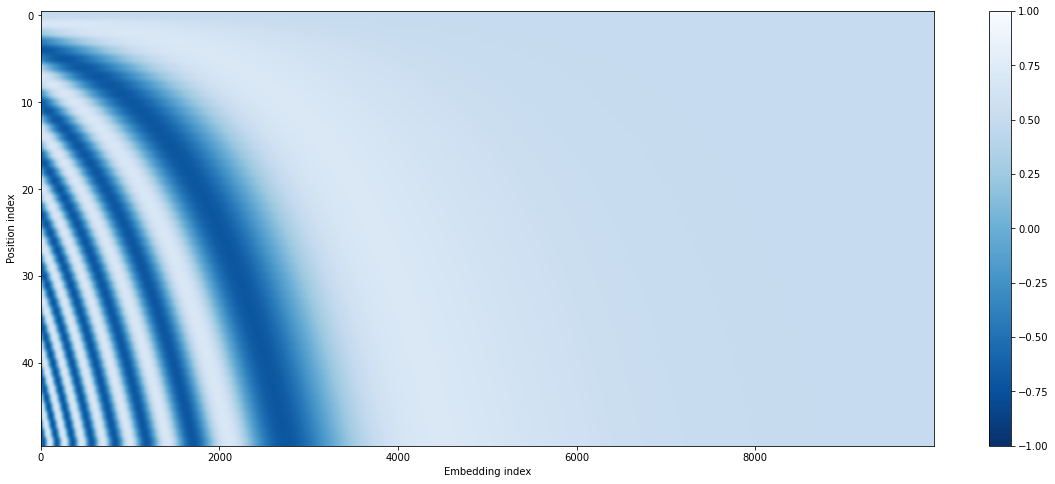

In [12]:
token_sequence_length = 50 # Number of tokens the model will need to process
token_embedding = 10000 # token embedding (and positional encoding) dimensions, ensure it is divisible by two
P = return_frequency_pe_matrix(token_sequence_length, token_embedding)
plot_position_encodings(P, token_sequence_length, token_embedding)

Looking at the graph above, we can see that for each position index, their is a unique pattern forming, where each position index will always have the same encoding. 

**Group task**:

- Discuss with your friend why we are seeing that specific pattern when `token_sequence_length` is 1000, and `token_embedding` is 768.
- You can try playing around with smaller values for `token_sequence_length` and  `token_embedding` to get a better intuition for the above discussion.
- Ask your friend why they think the 10000 constant is used in the functions above. 
- Make `token_sequence_length` to be 50 and `token_embedding` something large, like 10000. What do you notice? Is a large token embedding always needed?


**Math task (optional):** Notice in our function that we do not directly implement the equation we describe above for numerical stability when calculating the frequency steps. See if you can derive by hand how we got to this new equation. Hint: Think about log rules.

Original equation:

$\text{f} = \frac{D}{x^{i/d_{m}}}$

Code equation:

$\text{f} = \text{exp} \left( \frac{-i\log(x)}{d_m} \right)D$

###### **Answer (but first try yourself)**

Expand this section to see the answer. 

What we did here is an essential aspect of computer science, specifically in machine learning, when big numbers appear. We usually rewrite equations to utilise logs, such that multiplications become additions and large numbers get suppressed. This ensures better numerical stability.  

\begin{align}
    \frac{𝐷}{x^{𝑖/𝑑𝑚}} &= D\left( x^{-i/dm}\right) \\
    &= \text{exp}\left(\log{x^{-i/dm}}\right)D \\
    &= \text{exp}\left(\frac{-i}{dm}\log{x}\right)D\\
    &= \text{exp}\left(\frac{-i\log{x}}{dm}\right)D\\
\end{align}

##### **Learned positional embeddings**


Another method which is commonly used is to allow the model to learn the positional information required. In this method, the model learns a lookup table, where each index in the table refers to a positional embedding. Whereas the previous method allowed for an infinite amount of tokens, this method caps the maximum token sequence length as the lookup table has to be set beforehand. 

Using Haiku, this method is relatively straightforward as we can use [Haiku's embed function](https://dm-haiku.readthedocs.io/en/latest/api.html#embed) or [Haiku's get parameter function](https://dm-haiku.readthedocs.io/en/latest/api.html#get-parameter)

**Code Task:** Try and implement a lookup table, which can be learned, for using Haikus get parameter function.

In [ ]:
class PositionEmbeddingsLookup(hk.Module):
    """
    A position embedding of shape [max_sequence_len, d_model]
    """
    def __init__(self, max_sequence_len, d_model):
        super().__init__()

        self.max_sequence_len = max_sequence_len
        self.d_model = d_model

    def __call__(self, sequence):
        
        assert sequence.shape[0]<=self.max_sequence_len, f"Sequence to long, max lenght={self.max_sequence_len}"

        lookup_table = hk.get_parameter( 
            name="position_embedding",
            shape=, # FILL ME IN
            init=jnp.zeros
        )

        return lookup_table[:sequence.shape[0], :]

In [ ]:
# @title Answer to code task (Try not to peek until you've given it a good try!'). This answer will be based on our previous answer.

class PositionEmbeddingsLookup(hk.Module):
    """
    A position embedding of shape [max_sequence_len, d_model]
    """
    def __init__(self, max_sequence_len, d_model):
        super().__init__()

        self.max_sequence_len = max_sequence_len
        self.d_model = d_model

    def __call__(self, sequence):
        
        assert sequence.shape[0]<=self.max_sequence_len, f"Sequence to long, max lenght={self.max_sequence_len}"

        lookup_table = hk.get_parameter(
            name="position_embedding", 
            shape=(self.max_sequence_len, self.d_model),
            init=jnp.zeros
        )

        return lookup_table[:sequence.shape[0], :]


### Feed Forwad block

These blocks are just a single 2-layer MLP that uses ReLU activation in the original model, but GeLU has also become very popular, and we will be using it throughout the practical.

$$
\operatorname{FFN}(x)=\max \left(0, x W_{1}+b_{1}\right) W_{2}+b_{2}
$$

One can interpret this block as processing what the MHA block has produced and then projecting these new token representations to a space that the next block can use more optimally. Usually, the first layer is very wide, in the range of 2-8 times the size of the token representations. They do this as it is easier to parallelize computations for a single wider layer during training than to parallelize a feedforward block with multiple layers. Thus they can add in more complexity but keep training and inference optimized.

**Code task:** Code up a Haiku Module that impliments the Feed forward block. 

In [ ]:
class FeedForwardBlock(hk.Module):
  """A 2-layer MLP which widens then narrows the input."""

  def __init__(self,
               widening_factor: int = 4, 
               name):
    super().__init__(name=name)
    self._init_scale = 0.25
    self._widening_factor = widening_factor

  def __call__(self, x: jnp.ndarray) -> jnp.ndarray:
    d_m = x.shape[-1]
    layer1_size = self._widening_factor * d_m

    initializer = hk.initializers.VarianceScaling(self._init_scale)
    layer1 = # FINSIH ME
    layer2 = # FINISH ME

    x = jax.nn.gelu(layer1(x))
    x = layer2(x)
    return x

In [13]:
# @title Answer to code task (Try not to peek until you've given it a good try!') 

class FeedForwardBlock(hk.Module):
  """A 2-layer MLP which widens then narrows the input."""

  def __init__(self,
               widening_factor: int = 4,
               name=None):
    super().__init__(name=name)
    self._init_scale = .25
    self._widening_factor = widening_factor

  def __call__(self, x: jnp.ndarray) -> jnp.ndarray:
    d_m = x.shape[-1]
    layer1_size = self._widening_factor * d_m

    initializer = hk.initializers.VarianceScaling(self._init_scale)
    layer1 = hk.Linear(layer1_size, w_init=initializer)
    layer2 = hk.Linear(d_m, w_init=initializer)

    x = jax.nn.gelu(layer1(x))
    x = layer2(x)
    return x

### Add and Norm

In order to get transformers to go deeper, the residual connections are very important to allow an easier flow of gradients through the network. For normalisation, `layer norm` is used. This normalises each token vector independently in the batch. It is found that normalising the vectors improves the convergence and stability of transformers. 

There are two learnable parameters in layernorm, `scale` and `bias`, which rescales the normalised value. Thus, for each input token in a batch, we calculate the mean, $\mu_{i}$ and variance $\sigma_i^2$. We then normalise the token with:

$\hat{x}_i = \frac{x_i-$\mu_{i}}{\sigma_i^2 + ϵ}$.

Then $\hat{x}$ is rescaled using the learned `scale`, $γ$, and `bias` $β$, with:

$y_i = γ\hat{x}_i + β = LN_{γ,β}(x_i)$.

So our add norm block can be represented as $LN(x+f(x))$, where $f(x)$ is either a MLP or MHA block.

**Code task:** Code up a Haiku Module that impliments the add norm block. It should take as input the processed and unprocessed tokens. Hint: `hk.LayerNorm `

In [ ]:
class AddNorm(hk.Module):
  """A block that impliments the add and norm block"""

  def __init__(self,
               name=None):
    super().__init__(name=name)

  def __call__(self, x, processed_x):
    
    added = # FINISH ME
    normalised = #FINISH ME
    return normalised(added)

In [14]:
# @title Answer to code task (Try not to peek until you've given it a good try!') 

class AddNorm(hk.Module):
  """A block that impliments the add and norm block"""

  def __init__(self,
               name=None):
    super().__init__(name=name)

  def __call__(self, x, processed_x):
    
    added = x + processed_x
    normalised = hk.LayerNorm(axis=-1, create_scale=True, create_offset=True)
    return normalised(added)

### Building the Encoder 

We now have all the building blocks that we need to build a single encoder block. 

**Code task:** Use your previous builded modules and create a new haiku module that is a transformer encoder block. One should also be able to retrieve the attention weights as an optional flag.

In [ ]:
class EncoderBlock(hk.Module):
  """An encoder block for the Transformer stack."""

  def __init__(self, num_heads, d_m, widening_factor=4, name=None):
    super().__init__(name=name)

    self._num_heads = num_heads
    self.d_m = d_m
    self.mha = MultiHeadAttention(num_heads, d_m)
    self.add_norm1 = AddNorm()
    self.add_norm2 = AddNorm()
    self.MLP = FeedForwardBlock(widening_factor=widening_factor)

  def __call__(self, X, mask=None, return_att_weight=True):
    sequence_len = X.shape[-2]
    positions = # FINSIH ME
    X = X + positions
    attention, attention_weights = # FINISH ME
    X = self.add_norm1(X, attention)
    projection =  # FINISH ME
    X = # FINISH ME
    return (X, attention_weights) if return_att_weight else X

In [15]:
# @title Answer to code task (Try not to peek until you've given it a good try!') 

class EncoderBlock(hk.Module):
  """An encoder block for the Transformer stack."""

  def __init__(self, num_heads, d_m, widening_factor=4, name=None):
    super().__init__(name=name)

    self._num_heads = num_heads
    self.d_m = d_m
    self.mha = MultiHeadAttention(num_heads, d_m)
    self.add_norm1 = AddNorm()
    self.add_norm2 = AddNorm()
    self.MLP = FeedForwardBlock(widening_factor=widening_factor)

  def __call__(self, X, mask=None, return_att_weight=True):
    sequence_len = X.shape[-2]
    positions = return_frequency_pe_matrix(sequence_len, self.d_m)
    X = X + positions
    attention, attention_weights = self.mha(X, mask, return_weights=True)
    X = self.add_norm1(X, attention)
    projection = self.MLP(X)
    X = self.add_norm2(X, projection)
    return (X, attention_weights) if return_att_weight else X

Now that we have a single encoder block, lets create a new transformer encoder stack that stacks the encoder blocks into one single transformer encoder.

In [16]:
class TransformerEncoder(hk.Module):
  """Transformer encoder"""

  def __init__(self,
               num_heads: int,
               num_layers: int,
               d_m: int,
               widening_factor=4,
               name=None):
    super().__init__(name=name)
    self.num_layers = num_layers
    self.num_heads = num_heads
    self.widening_factor = widening_factor
    self.blocks = [
      EncoderBlock(self.num_heads, d_m, self.widening_factor) for _ in range(num_layers)
    ]
  def __call__(self, X, mask, return_att_weights=False):
    if return_att_weights:
      att_weights = []
    
    for block in self.blocks:
      out = block(X, mask, return_att_weights)

      if return_att_weights:
        X = out[0]
        att_weights.append(out[1])
      else:
        X = out
    
    return X if not return_att_weights else (X, jnp.array(att_weights).swapaxes(0,1))

In [17]:
B, T, d_m, N = 4, 33, 16, 8

# run this to test if your code is running
def encode(sequences, num_heads=2, num_layers=2, widening_factor=4, d_m=d_m, return_weights=True):
  encoder = TransformerEncoder(num_heads, num_layers, d_m, widening_factor)
  return encoder(sequences,None,return_weights)

encode = hk.transform(encode)

# initialise module
key = jax.random.PRNGKey(42)
X = jax.random.normal(key, [B, T,d_m])
print('BEFORE SHAPE:')
print(X.shape)
params = encode.init(key, X, N, d_m)
new_x = encode.apply(params, key, X)
print('AFTER SHAPE:')
new_x[0].shape

BEFORE SHAPE:
(4, 33, 16)
AFTER SHAPE:


(4, 33, 16)

### Building the Decoder

Most of the ground work has now already happened. The only difference now is that we must pass the encoder outputs to each of the decoder blocks and apply the extra MHA block.

In [18]:
class DecoderBlock(hk.Module):
  """An decoder block for the Transformer stack."""

  def __init__(self, num_heads, d_m, widening_factor=4, name=None):
    super().__init__(name=name)

    self._num_heads = num_heads
    self.d_m = d_m
    self.mha = MultiHeadAttention(num_heads, d_m)
    self.mha_combine = MultiHeadAttention(num_heads, d_m)
    self.add_norm1 = AddNorm()
    self.add_norm2 = AddNorm()
    self.add_norm3 = AddNorm()
    self.MLP = FeedForwardBlock(widening_factor=widening_factor)

  def __call__(self, X, encoder_output , mask=None, return_att_weight=True):
    sequence_len = X.shape[-2]
    positions = return_frequency_pe_matrix(sequence_len, self.d_m)
    X = X + positions
    

    attention, attention_weights_1 = self.mha(X, mask=mask, return_weights=True)
    
    X = self.add_norm1(X, attention)
    
    attention, attention_weights_2 = self.mha_combine(
        Q=encoder_output,
        K=X,
        V=X,
        mask=mask,
        return_weights=True
    )
    
    X = self.add_norm2(X, attention)
    projection = self.MLP(X)
    X = self.add_norm3(X, projection)

    return (X, attention_weights_2) if return_att_weight else X

As you can see in the code, we now use the encoder outputs passed to the module when calculating the final attention weights before feeding everything through the MLP. 

Next, we just put everything together, just like we did for the encoder.

In [19]:
class TransformerDecoder(hk.Module):
  """Transformer Decoder"""

  def __init__(self,
               num_heads: int,
               num_layers: int,
               d_m: int,
               widening_factor=4,
               name=None):
    super().__init__(name=name)
    self.num_layers = num_layers
    self.num_heads = num_heads
    self.widening_factor = widening_factor
    self.blocks = [
      DecoderBlock(self.num_heads, d_m, self.widening_factor) for _ in range(num_layers)
    ]
  def __call__(self, X, encoder_output, mask, return_att_weights=False):
    if return_att_weights:
      att_weights = []
    for block in self.blocks:
      out = block(X, encoder_output, mask, return_att_weights)
      if return_att_weights:
        X = out[0]
        att_weights.append(out[1])
      else:
        X = out
  
    return X if not return_att_weights else (X, jnp.array(att_weights).swapaxes(0,1))

In [ ]:
B, T, d_m, N = 18, 32, 16, 8

# run this to test if your code is running
def encode(sequences, encoder_output, num_heads=2, num_layers=2, widening_factor=4, d_m=d_m, return_weights=True):
  print(encoder_output.shape)
  decoder = TransformerDecoder(num_heads, num_layers, d_m, widening_factor)
  return decoder(sequences,encoder_output,None,return_weights)

encode = hk.transform(encode)

# initialise module
key = jax.random.PRNGKey(42)
X = jax.random.normal(key, [B, T,d_m])
encoder_output = jax.random.normal(key, [B, T,d_m])
params = encode.init(key, X, encoder_output, N, d_m)
new_y = encode.apply(params, key, X, encoder_output)
print('AFTER SHAPE:')
new_y[0].shape

(18, 32, 16)
(18, 32, 16)
AFTER SHAPE:


(18, 32, 16)

### Putting it all together

There is nothing more to it. We have built every single component required to build a transformer, now we just have to combine everything into one module. 

**Code task**: Build a encoder-decoder transformer haiku module.

In [ ]:
class Transformer(hk.Module):
  """A full transformer encoder-decoder architecture"""

  def __init__(self, num_heads, num_layers, d_m, widening_factor=4, name=None):
    super().__init__(name=name)

    self.num_layers = num_layers
    self.num_heads = num_heads

    self.encoder = # FINISH ME
    self.decoder = # FINISH ME

   def __call__(self, X_encoder, X_decoder, encoder_mask, decoder_mask, return_weights):
    encoder_out = # FINISH ME 
    attention_input = encoder_out[0] if return_weights else encoder_out
    decoder_out = # FINISH ME
    logits = decoder_out[0] if return_weights else decoder_out

    return logits if not return_weights else (logits, encoder_out[1], decoder_out[1])   

In [20]:
# @title Answer to code task (Try not to peek until you've given it a good try!') 

class Transformer(hk.Module):
  """A full transformer encoder-decoder architecture"""

  def __init__(self, num_heads, num_layers, d_m, widening_factor=4, name=None):
    super().__init__(name=name)
    self.num_layers = num_layers
    self.num_heads = num_heads

    self.encoder = TransformerEncoder(
        num_heads, 
        num_layers, 
        d_m, 
        widening_factor
    )
    self.decoder = TransformerDecoder(
        num_heads, 
        num_layers, 
        d_m, 
        widening_factor
    )

  def __call__(self, X_encoder, X_decoder, encoder_mask, decoder_mask, return_weights):
    encoder_out = self.encoder(X_encoder, encoder_mask, return_weights)
    attention_input = encoder_out[0] if return_weights else encoder_out
    decoder_out = self.decoder(X_decoder, attention_input, decoder_mask, return_weights)
    logits = decoder_out[0] if return_weights else decoder_out

    return logits if not return_weights else (logits, encoder_out[1], decoder_out[1])

If everything is correct, then if we run the code below, everything should run without any issues.

In [21]:
B, T, d_m, N = 18, 32, 16, 8

# run this to test if your code is running
def tranformer(sequences, num_heads=1, num_layers=1, widening_factor=4, d_m=d_m, return_weights=True):
  transform = Transformer(num_heads, num_layers, d_m, widening_factor)
  mask = jnp.tril(np.ones((sequences.shape[1], sequences.shape[1])))
  return transform(sequences, sequences, None, mask, return_weights)

tranformer = hk.transform(tranformer)

# initialise module and get dummy output
key = jax.random.PRNGKey(42)
X = jax.random.normal(key, [B, T,d_m])
params = tranformer.init(
    key, X, num_heads=1, num_layers=1, widening_factor=4, d_m=d_m, return_weights=True
)

# extract output from decoder
logits, encoder_att_weights, decoder_att_weights = tranformer.apply(
    params, key, X, num_heads=1, num_layers=1, widening_factor=4, d_m=d_m, return_weights=True
)

As a final sanity check, we can see that our attention weights behave as expected for now. The encoder weights can attend to all input sequences, and our decoder only attends to previous tokens.

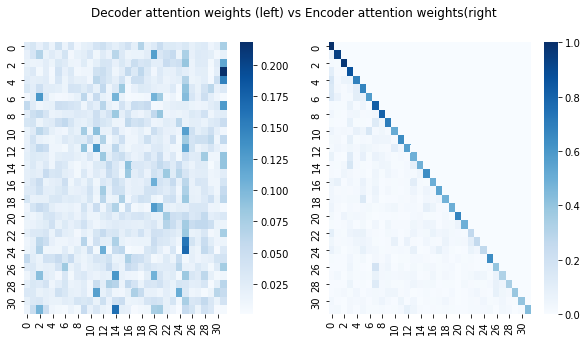

In [22]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
plt.suptitle('Decoder attention weights (left) vs Encoder attention weights(right')
sns.heatmap(encoder_att_weights[0,0,0,...], ax=ax[0],cmap='Blues')
sns.heatmap(decoder_att_weights[0,0,0,...], ax=ax[1],cmap='Blues')
fig.show()

### Training our model to invert sentence

To showcase the encoder-decoder transformer model we have just created, we will train it to reverse the order of an input string. For example:

- *Input*: "Look at me, I am reveresed."
- *Output*: "reversed am I, look at me"

Some might even say a little Yoda simulator ;) 

#### Creating our dataset

We will use the tinyShakespear hosted by Andrej Karpathy [here](https://github.com/karpathy/char-rnn).

In [23]:
# Download data set
! wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt -O input.txt

--2022-07-27 10:27:15--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.007s  

2022-07-27 10:27:15 (146 MB/s) - ‘input.txt’ saved [1115394/1115394]



Next, we need to build a dataset class that will return a sample of text from tinyShakespear and the reversed version of the sentence. For now, do not worry too much about how this class works. It is just a way to iteratively run over the dataset and randomly sample snippets of text for an "infinite" number of steps.

Another critical step to note is that we tokenize the data at a char level. In other words, all text is split and encoded to a unique ASCII value, with 128 unique values. The model will thus receive a sequence of integers, where we can then learn a lookup table of vectors for each ASCII character.

In [24]:
BREAK_ORDS = (ord(' '), ord('\n'), ord('\t'), ord('.'))

def ord_to_char(list_of_ords):
  """Format ascii np.array to char"""
  return''.join([chr(o) for o in list_of_ords])

class AsciiDatasetForInversionTask:
  """In-memory dataset of a single-file ASCII dataset for inversion task."""

  def __init__(self, path: str, batch_size: int, sequence_length: int):
    """Load a single-file ASCII dataset in memory."""
    self.vocab_size = 128
    self._batch_size = batch_size

    with open(path, 'r') as f:
      corpus = f.read()

    if not corpus.isascii():
      raise ValueError('Loaded corpus is not ASCII.')

    if '\0' in corpus:
      # Reserve 0 codepoint for pad token.
      raise ValueError('Corpus must not contain null byte.')

    # Tokenize by taking ASCII codepoints.
    corpus = np.array([ord(c) for c in corpus if c!='\n']).astype(np.int32)
    assert np.min(corpus) > 0
    assert np.max(corpus) < self.vocab_size  # Double-checking ASCII codepoints.

    crop_len = sequence_length + 1
    num_batches, ragged = divmod(corpus.size, batch_size * crop_len)
    if ragged:
      corpus = corpus[:-ragged]
    corpus = corpus.reshape([-1, crop_len])

    if num_batches < 10:
      raise ValueError(f'Only {num_batches} batches; consider a shorter '
                       'sequence or a smaller batch.')

    self._ds = AsciiDatasetForInversionTask._infinite_shuffle(corpus, batch_size * 10)

  def __next__(self):
    """Yield next mini-batch."""
    batch = [next(self._ds) for _ in range(self._batch_size)]
    batch = np.stack(batch)
    # Create the language modeling observation/target pairs.
    return dict(input=batch[:, :], target=AsciiDatasetForInversionTask.invert_batch(batch))

  def __iter__(self):
    return self

  @staticmethod
  def invert_batch(batch):
    inverted_batch = []
    for instance in batch:
      inverted_batch.append([])
      last_seen_space_index = len(instance)
      for i in range(len(instance)-1, -1, -1):
        if instance[i] in BREAK_ORDS:
          inverted_batch[-1].extend(instance[i+1:last_seen_space_index])
          inverted_batch[-1].append(instance[i])
          last_seen_space_index = i
      inverted_batch[-1].extend(instance[i:last_seen_space_index])
    return np.array(inverted_batch)

  @staticmethod
  def _infinite_shuffle(iterable, buffer_size):
    """Infinitely repeat and shuffle data from iterable."""
    ds = itertools.cycle(iterable)
    buf = [next(ds) for _ in range(buffer_size)]
    random.shuffle(buf)
    while True:
      item = next(ds)
      idx = random.randint(0, buffer_size - 1)  # Inclusive.
      result, buf[idx] = buf[idx], item
      yield result


Now that we can load data and return infinite batches, lets see it in action.

In [25]:
batch_size = 2
seq_length = 32
train_dataset = AsciiDatasetForInversionTask(
    'input.txt', batch_size, seq_length)
vocab_size = train_dataset.vocab_size

batch = next(train_dataset)

for obs, target in zip(batch['input'], batch['target']):
  print("-" * 10, 'Input', "-" * 11)
  print('TEXT:', ord_to_char(obs))
  print('ASCII:', obs)
  print("-" * 10, 'Target', "-" * 10)
  print('TEXT:', ord_to_char(target))
  print('ASCII:', target)


print(f'\n Total vocabulary size: {vocab_size}')

---------- Input -----------
TEXT: rst Citizen:First, you know Caius
ASCII: [114 115 116  32  67 105 116 105 122 101 110  58  70 105 114 115 116  44
  32 121 111 117  32 107 110 111 119  32  67  97 105 117 115]
---------- Target ----------
TEXT: Caius know you Citizen:First, rst
ASCII: [ 67  97 105 117 115  32 107 110 111 119  32 121 111 117  32  67 105 116
 105 122 101 110  58  70 105 114 115 116  44  32 114 115 116]
---------- Input -----------
TEXT:  on't; let it be done: away, away
ASCII: [ 32 111 110  39 116  59  32 108 101 116  32 105 116  32  98 101  32 100
 111 110 101  58  32  97 119  97 121  44  32  97 119  97 121]
---------- Target ----------
TEXT: away away, done: be it let on't; 
ASCII: [ 97 119  97 121  32  97 119  97 121  44  32 100 111 110 101  58  32  98
 101  32 105 116  32 108 101 116  32 111 110  39 116  59  32]

 Total vocabulary size: 128


#### Training objective

**Viewing it as a classification task**

Given an input sequence, which is a sequence of ASCII characters in this specific use case, our model should learn to take that sequence and reverse it. 

This can be framed as a sequence-2-sequence problem, where the decoder should predict the sequence, given the processed information from the encoder and the original sequence.

The loss function will then be the sum of the loss over each token. The loos will be cross-entropy, where the ASCII token is the correct label to predict. Take note, that because the sequence can be padded during training, the loss is also masked to ignore the result on padded tokens. 

<img src="https://drive.google.com/uc?export=view&id=16-F7uCuJEvFn3e9PgpJpEQmsuMAUkCLT" alt="drawing" width="290"/>

**Code task**: Implimement the cross entropy loss function below. 

In [ ]:
def sequence_loss_fn(logits, data):
  targets = jax.nn.one_hot(data['target'], 128)
  assert logits.shape == targets.shape

  mask = jnp.greater(data['input'], 0)
  loss = #FINSIH ME
  return loss

In [26]:
# @title Answer to code task (Try not to peek until you've given it a good try!') 
def sequence_loss_fn(logits, data):
  """Compute the loss on data wrt params."""
  targets = jax.nn.one_hot(data['target'], 128)
  assert logits.shape == targets.shape
  mask = jnp.greater(data['input'], 0)
  loss = -jnp.sum(targets * jax.nn.log_softmax(logits), axis=-1)
  loss = jnp.sum(loss * mask) / jnp.sum(mask)

  return loss

**Viewing it as an generative task**

We can also solve this problem by iteratively generating a ASCII id, based on the previously generated ASCII's and input sequence.


\

<img src="https://drive.google.com/uc?export=view&id=16w-p0V2VFkocfCg0Y1LpS-pzWriQFmHq" alt="drawing" width="290"/>


We are in essence then trying to model the distrubution: 

$$
P\left(y_{1}, y_{2}, \ldots, y_{n}, \mid x\right)=\prod_{t=1}^{n} p\left(y_{t} \mid y_{<t}, x\right)
$$

The loss function will not change, but the way we feed our data into the decoder will be different. We will 


#### Training and inspecting models

In the next section, we define all the processes required to train the model using the two objectives described above. A lot of this is now the work required to do training using Haiku. 

Below we define the forward functions that we can wrap in the transform function from Haiku. These functions take in our data and produce our logits as a full parallel prediction or generative iteratively.

Please take note that in the below function, the ASCI characters are encoded using a lookup table and that there is an MLP at the end that predicts ASCI characters from our decoded token embeddings. 

In [171]:
def build_forward_fn(vocab_size, d_model, num_heads, num_layers, widening_factor, generative=False):
  def forward_fn(data, return_weights=False, vocab_size=vocab_size):
    """Forward pass."""
    tokens = data['input']
    tokens_target = data['target']

    # if generative, we need new token to say start generating
    if generative:
      vocab_size = vocab_size + 1

    # Embed the input tokens and positions. 
    embed_init = hk.initializers.TruncatedNormal(stddev=0.02)
    token_embedding_map = hk.Embed(vocab_size, d_model, w_init=embed_init)
    token_embs = token_embedding_map(tokens)
    
    # Run the transformer over the inputs.
    transformer = Transformer(num_heads, num_layers, d_model, widening_factor)

    if generative:
      
      # inject "start" token into target codes
      start_token = jnp.ones((tokens_target.shape[0], 1))+vocab_size # new ID meaning in reality just to start
      tokens_target = jnp.concatenate((start_token, tokens_target), axis=1)
      token_target_emb = token_embedding_map(tokens)
      decoding_mask = jnp.tril(jnp.greater(tokens_target, 0))


      output_embeddings, weights1, weights2 = transformer(
          token_embs, token_target_emb, None, decoding_mask, return_weights=True
      )
      # Predict the token IDs
      logits = hk.Linear(vocab_size-1)(output_embeddings)
      
    else:

      output_embeddings, weights1, weights2 = transformer(
          token_embs, token_embs, None, None, return_weights=True
      )
      # Predict the token IDs
      logits = hk.Linear(vocab_size)(output_embeddings)

    return logits if not return_weights else (logits, weights1, weights2)
  return forward_fn


##### Training parralel classifier

Next we need to initilalise our model and setup our optimiser using optax. Feel free to play with hyperparameters. We also set up the training data here again to easy hyperparameter changes.

In [172]:
d_model = 128
num_heads = 8
num_layers = 3
widening_factor = 2
LR = 1e-3

batch_size = 64
seq_length =  32
generative = False

# set up the data
train_dataset = AsciiDatasetForInversionTask(
    'input.txt', batch_size, seq_length
)
vocab_size = train_dataset.vocab_size
batch = next(train_dataset)

# initialise model
rng = jax.random.PRNGKey(42)
forward_fn = hk.transform(build_forward_fn(vocab_size, d_model, num_heads, num_layers, widening_factor, generative))
params = forward_fn.init(rng, batch)

# set up the optimiser
optimiser = optax.chain(
    optax.clip_by_global_norm(1),
    optax.adam(LR, b1=0.9, b2=0.99)
)
opt_state = optimiser.init(params)


In [173]:
#@title Haiku functions

# set up function calculating loss
def loss(params, batch):
  vocab_size=128
  key = jax.random.PRNGKey(42)
  logits = forward_fn.apply(params, key, batch)
  batch_loss = sequence_loss_fn(logits, batch)
  return batch_loss


@jax.jit
def update(params, opt_state, batch):
  # get data neded for training
  grads = jax.grad(loss)(params, batch)
  updates, opt_state = optimiser.update(grads, opt_state)
  params = optax.apply_updates(params, updates)
  return params, opt_state

# calculate loss per batch
@jax.jit
def calculate_batch_loss(params, batch, vocab_size):
  key = jax.random.PRNGKey(42)
  logits = forward_fn.apply(params, key, batch)
  
  return sequence_loss_fn(logits, batch)


# get the model output
def get_model_prediction(params, data, return_weights=False):
  key = jax.random.PRNGKey(42)
  logits, encoder_weights, decoder_weights = forward_fn.apply(params, key, data, True)
  argmax_out = jnp.argmax(logits, axis=-1)
  tokens = [ord_to_char(out) for out in argmax_out]
  
  if return_weights:    
    return tokens, encoder_weights, decoder_weights
  else:
    return tokens

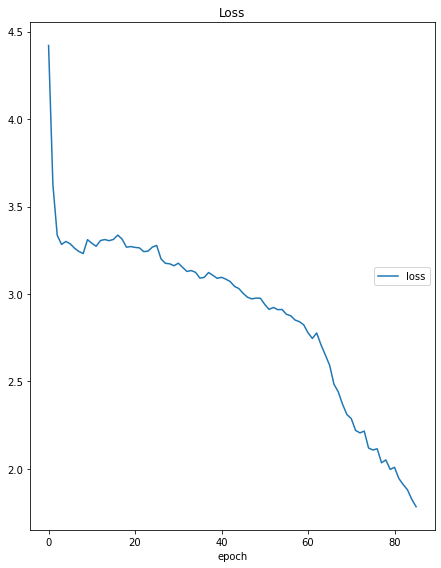

Loss
	loss             	 (min:    1.784, max:    4.421, cur:    1.784)


In [ ]:
plotlosses = PlotLosses()

MAX_STEPS = 1200
LOG_EVERY = 8
losses = []

plotlosses = PlotLosses()

key = jax.random.PRNGKey(42)

# Training & evaluation loop.
for step in range(MAX_STEPS):
  data = next(train_dataset)
  params, opt_state = update(params, opt_state, data)
  losses.append(calculate_batch_loss(params, data, vocab_size))

  if step % LOG_EVERY == 0:
    loss_ = jnp.array(losses).mean()
    plotlosses.update({
      'loss': loss_,
    })
    plotlosses.send()
    losses = []

In [ ]:
data = next(train_dataset)

predicted_string, encoder_weights, decoder_weights = get_model_prediction(params, data, True)
target_string =[ord_to_char(t) for t in data['target']]
input_string =[ord_to_char(t) for t in data['input']]

for y_hat, y, input_ in zip(predicted_string[:2], target_string[:2], input_string[:2]):
      print("-" * 10, 'Input', "-" * 11)
      print(input_)
      print("-" * 10, 'Target', "-" * 10)
      print(y)
      print("-" * 10, 'Prediction', "-" * 10)
      print(y_hat)
      print()
      print('*'*50)

Lets plot the average attention matrices over a batch of data, and see what our model has learned. This is a very typical process in transformer development and evaluation.

In [ ]:
def plot_weights(mean_weights, num_layers, num_heads, block='Encoder'):
  for layer in range(num_layers):
    fig, ax = plt.subplots(1,num_heads, figsize=(45,5))
    plt.suptitle(f'Encoder Layer {layer} attention heads')
    for h in range(num_heads):
      ax[h].set_title(f'Head {h}')
      sns.heatmap(mean_weights[layer,h,...], ax=ax[h],cmap='Blues')
    fig.show()

In [ ]:
mean_encoder_weights = jnp.mean(encoder_weights,axis=0)
plot_weights(mean_encoder_weights, num_layers, num_heads, block='Encoder')

In [ ]:
mean_decoder_weights = jnp.mean(decoder_weights,axis=0)
plot_weights(mean_decoder_weights, num_layers, num_heads, block='Decoder')

**Group task**: Discuss with your friend wheter these outputs make sense.

##### Training generator

Next, let us train our generator and see how it performs. The previous method could have been solved by just using the encoder part, but now we show it is possible by utilising the decoder-specific changes.

In [ ]:
d_model = 64
num_heads = 8
num_layers = 2
widening_factor = 4
LR = 1e-3

batch_size = 64
seq_length =  16
generative = True

# set up the data
train_dataset = AsciiDatasetForInversionTask(
    'input.txt', batch_size, seq_length
)
vocab_size = train_dataset.vocab_size
batch = next(train_dataset)

# initialise model
rng = jax.random.PRNGKey(42)
forward_fn = hk.transform(build_forward_fn(vocab_size, d_model, num_heads, num_layers, widening_factor, generative))
params = forward_fn.init(rng, batch)

# set up the optimiser
optimiser = optax.chain(
    optax.clip_by_global_norm(1),
    optax.adam(LR, b1=0.9, b2=0.99)
)
opt_state = optimiser.init(params)


In [ ]:
#@title Haiku functions

# # set up function calculating loss
# def loss(params, batch):
#   vocab_size=128
#   key = jax.random.PRNGKey(42)
#   logits = forward_fn.apply(params, key, batch)
#   batch_loss = sequence_loss_fn(logits, batch)
#   return batch_loss


# @jax.jit
# def update(params, opt_state, batch):
#   # get data neded for training
#   grads = jax.grad(loss)(params, batch)
#   updates, opt_state = optimiser.update(grads, opt_state)
#   params = optax.apply_updates(params, updates)
#   return params, opt_state

# # calculate loss per batch
# @jax.jit
# def calculate_batch_loss(params, batch, vocab_size):
#   key = jax.random.PRNGKey(42)
#   logits = forward_fn.apply(params, key, batch)
  
#   return sequence_loss_fn(logits, batch)


# # get the model output
# def get_model_prediction(params, data, return_weights=False):
#   key = jax.random.PRNGKey(42)
#   logits, encoder_weights, decoder_weights = forward_fn.apply(params, key, data, True)
#   argmax_out = jnp.argmax(logits, axis=-1)
#   tokens = [ord_to_char(out) for out in argmax_out]
  
#   if return_weights:    
#     return tokens, encoder_weights, decoder_weights
#   else:
#     return tokens

In [ ]:
plotlosses = PlotLosses()

MAX_STEPS = 4500
LOG_EVERY = 32
losses = []

key = jax.random.PRNGKey(42)
# Training & evaluation loop.
for step in range(MAX_STEPS):
  data = next(train_dataset)
  params, opt_state = update(params, opt_state, data)
  losses.append(calculate_batch_loss(params, data, vocab_size))

  if step % LOG_EVERY == 0:
      loss_ = jnp.array(losses).mean()
      plotlosses.update({
        'loss': loss_,
      })
      plotlosses.send()
      losses = []

In [ ]:
key = jax.random.PRNGKey(42)
logits1 = forward_fn.apply(params, key, data, False)
argmax_out = jnp.argmax(logits, axis=-1)
tokens = [ord_to_char(out) for out in argmax_out]

logits2, encoder_weights, decoder_weights = forward_fn.apply(params, key, data, True)


In [ ]:
data = next(train_dataset)

predicted_string, encoder_weights, decoder_weights = get_model_prediction(params, data, True)
target_string =[ord_to_char(t) for t in data['target']]
input_string =[ord_to_char(t) for t in data['input']]

for y_hat, y, input_ in zip(predicted_string[:2], target_string[:2], input_string[:2]):
      print("-" * 10, 'Input', "-" * 11)
      print(input_)
      print("-" * 10, 'Target', "-" * 10)
      print(y)
      print("-" * 10, 'Prediction', "-" * 10)
      print(y_hat)
      print()
      print('*'*50)

In [ ]:
mean_encoder_weights = jnp.mean(encoder_weights,axis=0)
plot_weights(mean_encoder_weights, num_layers, num_heads, block='Encoder')

In [ ]:
mean_decoder_weights = jnp.mean(decoder_weights,axis=0)
plot_weights(jnp.where(mean_decoder_weights==1, 0.5, mean_decoder_weights), num_layers, num_heads, block='Decoder')

### Decoder / Encoder only models

[JUST TALK ABOUT THAT THERE EXIST DECODER ONLY, ENCODER ONLY, AND ENCODER-DECODER MODELS AND LINK TO THEM]

### Section Quiz 

Optional end of section quiz. Below is an example of an assessment.

In [ ]:
#@title Generate Quiz Form. (Run Cell)
from IPython.display import HTML
HTML(
"""
<iframe 
	src="https://forms.gle/zbJoTSz3nfYq1VrY6",
  width="80%" 
	height="1200px" >
	Loading...
</iframe>
"""
)

## **Hugging Face** - OPTIONAL (but recommended)



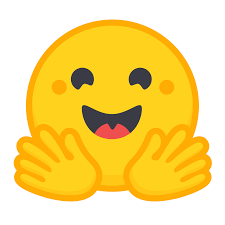


[Hugging Face](https://huggingface.co/) is a startup founded in 2016 and, in their own words: "are on a mission to democratize good machine learning, one commit at a time."

They have developed various open-source packages and allow users to easily interact with a large corpus of pretrained transformer models (across all modalities) and datasets to train or fine-tune pre-trained transformers.

Their software is used widely in industry and research. The following sections show how one can interact with their various features, access SOTA models, and train your own model.

This is an optional section for the practical. Still, working through it in the practical or afterwards is highly recommended. Understanding Hugging Face will allow you to build a very quick proof of concept system to test out various hypotheses, whereafter, the system you build can simply be used, or a new system can be developed with the knowledge that the original idea has merit. 

It should also be noted that various languages are still severely under-resourced, even in this ecosystem. See it as an opportunity also to see where the gaps are and how we as a community can reduce this gap. 

### Datasets Package - <font color='blue'>`Beginner`</font>

Along with all the models being availible, datasets are also hosted on the hugginface hub. One can visit the [dataset hub](https://huggingface.co/datasets), and browse for interesting datasets and very easilly access it through the [datasets](https://github.com/huggingface/datasets) package.

Lets say for instance we want to build an text intent classification model. What we do then is to go to the link above, and use the search tags to find a dataset that seems like a good fit for us. Doing this, we find the [`banking77`](https://huggingface.co/datasets/banking77) dataset. Below we then load in this dataset.


In [ ]:
# just for notebook cleanliness
from datasets.utils.logging import set_verbosity_error
from datasets import load_dataset

dataset = load_dataset("banking77")
print(dataset)

Here we see that the API returns a variable of DatasetDict type, which containins our dataset that has split into two datasets, i.e. train and test splits. We also see that each of these datasets contain `text` and `label` features. 

Lets investigate how the data looks.

In [ ]:
dataset['train']

We see that our dataset splits are of type Dataset.

In [ ]:
train_intents = dataset['train']
test_intents = dataset['test']

print('Text: ', train_intents['text'][0])
print('Label: ', train_intents['label'][0])

Sometimes we want to work with only a subset of the dataset and we thus need to filter out the rest. Luckilly, the datasets have an easy to use filter functionality. Below we filter to only see text which relates to label 11. 

In [ ]:
# we are only the first 5 text samples
train_intents.filter(lambda data: data['label']==1)

We can also apply a function to each data item by mapping the function to each "row" in the dataset.

In [ ]:
# creating small dataset as example of using select
example_dataset = train_intents.select(range(10))

# printing first character of a text example
example_dataset.map(lambda example: print(example['text'][0]));

Using the map function, we can also add a new collumn.

In [ ]:
def add_sentence_len(example):
    example['lenght'] = len(example['text'])
    return example

# add new column
example_dataset = example_dataset.map(lambda example: add_sentence_len(example))

print(example_dataset)
print('New data:', example_dataset['lenght'])

**Code Task**: 
- We want to build a classifier out of this. We need to investigate the distrubution of classes to see if our dataset is balanced or not. Write code that generates a dictionary containing the count of each class for both the train and test dataset.
- Filter out classes with less than 150 classes in the training set, and ensure only the remaining classes are in the test test. 

In [ ]:
# task 1
unique_labels = # FINISH ME
total_unique_labels = # FINISH ME

train_counts = # FINISH ME
test_counts = # FINISH ME

# task 2
passed_labels = [label for label, count in train_counts.items() if count>=150]
train_intents = # FINISH ME
test_intents = # FINISH ME

In [ ]:
# @title Answer to code task (Try not to peek until you've given it a good try!'). This answer will be based on our previous answer.

# # task 1
unique_labels = np.unique(train_intents['label'])
total_unique_labels = len(unique_labels)

train_counts = {label:sum(label==train_intents['label']) for label in unique_labels}
test_counts = {label:sum(label==train_intents['label']) for label in unique_labels}

# task 2
passed_labels = [label for label, count in train_counts.items() if count>=150]
train_intents = train_intents.filter(lambda data: data['label'] in passed_labels)
test_intents = test_intents.filter(lambda data: data['label'] in passed_labels)

**Other modalities**

Text is not the only data that can be accessed, audio and image data can be accessed just as easilly. 

In [ ]:
from PIL import Image
from io import BytesIO

dataset = load_dataset("cgarciae/cartoonset")
Image.open(BytesIO(dataset['train']["img_bytes"][231]))

# # free up a bit of space
del dataset

### Transformers Package

Now that we have a way in accessing data, lets shift our intention to accessin the hundreds of pretrained transformers.

#### Pipeline - <font color='blue'>`Beginner`</font>

The easiest method to access a vast range of pre-trained models and use tasks is through the `pipeline` API.

Pipelines group together a pretrained model found on their models hub with the preprocessing that was used during that model's training. To use the pipeline, one must import it from the [transformers](https://github.com/huggingface/transformers) library and specify the task and model you want.

For a list of models, visit [this](https://huggingface.co/models) page that allows you to search through all models currently on the hub.

In [ ]:
# When calling the function for the first time, the model, and its tokenizer, will be automatically downloaded
sentiment_model = pipeline(task='sentiment-analysis', model='distilbert-base-uncased-finetuned-sst-2-english')
print(sentiment_model("I love this practical!"))
print(sentiment_model("I hate this practical!"))

# passing more than one sentence
sentence_batch = [
  'This is much quicker and easier to build a POC with than training everything from scratch',
  'It really hurts when I stub my toe',
  'I want to get ice cream'
]
print('\nBatch output:')
sentiment_model(sentence_batch)

Notice that the first sentence we process in our batch of sentences is predicted to be Negative, with a relative low score of $0.51$, even though we feel this should be more neutral? The low score indicates this and we can interepet that when scores are low the actual label was meant to be Neutral, but this model was trained to do a binary prediction only.

This model you just used is a Distellbert model, which was trained on *8 16GB V100s for 90 hours*, and you could use it as quickly as that.

**Code Task:** Apply the zero shot model to all of our test intent chatbot examples, extracting the predicted senitment label into a new collumn, using the map function.

In [ ]:
def get_sentiment(example):
  # FINISH ME
  return sentiment

train_intents = # FINISH ME
test_intents = # FINISH ME

In [ ]:
# @title Answer to code task (Try not to peek until you've given it a good try!'). This answer will be based on our previous answer.
def get_sentiment(example):
  example['sentiment'] = sentiment_model(example['text'])[0]['label']
  return example

test_intents = test_intents.map(lambda example: get_sentiment(example))

In [ ]:
plt.title('Count of positive versus negative text inputs')
sns.countplot(test_intents['sentiment']);

**Group code task (optional depending on time)**: (Hint: use the tags when searching the [model hub](https://huggingface.co/models))
- Search for other pipeline tasks available, and dicuss with your friend what you did and found. ([Hint](https://huggingface.co/docs/transformers/v4.20.1/en/main_classes/pipelines#pipelines))
- Play with different language models and see how they perform

In [ ]:
your_pipeline = pipeline(
    task='text-generation', # CHANGE ME TO OTHER STUFF
    model='gpt2' # CHANGE ME AS WELL
)
text = 'I like ice-cream and '
your_pipeline(text)

In [ ]:
# freeing up memory for future tasks
del your_pipeline
del sentiment_model

#### Training a chatbot intent model  - <font color='blue'>`Advanced`</font>

If you want more controll than the pipeline API provides you, you can also use the predefined model classes. 

To showcase this, we will be training a custom model on top of a large transformer.

To set the scene, lets say for instance that we want to train an intent model that can be used along with a chatbot. This intent model will be responsible to predict the true underlying intent found within the text. 

Your imaganiry friend has built an intent model using TF-IDF techniques, but you think that you can use transformers for this task and that it will perform better. 

You have heard about the famous [DistilBERT](https://arxiv.org/pdf/1910.01108.pdf) model that was trained to extract text features, and yout think this model can be a perfect fit to extract features for your intent model, as it is an encoder only transformer architecture that produces strong token representations.

To start your training process, you have two steps to follow:

* Get the tokenizer
* Get the model

###### **Getting the tokenizer**

A tokenizer is responsible for preprocessing text into a format that is understandable to the model. It is very important to use the same tokenizer as the model you will be finetuning.  

In [ ]:
# we want the Distilbert model, thus we import the correct tokenizer the model train
from transformers import DistilBertTokenizer

# we specify a specif distilbert 
model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(model_name)

print('Tokenizer output:')
output = tokenizer('This is example text')
print(output)

print('Tokens converted back to string')
print(tokenizer.decode(output['input_ids']))

Looking at the output from the above, we that the special tokens are the `[CLS]` and `[SEP]` tokens. This is important to note, as we will be using the final output of the model for the `[CLS]` token when predicting the intent. 

This is a very common thing to do, where the token that indicates the start of the sentence is used when making predictions on the sentence. Seeing as our system is built in Jax, we will need to tell the tokenizer to return the data in the correct format.


In [ ]:
token_batch = tokenizer(
    ["We are very happy to show you the 🤗 Transformers library.", "We hope you don't hate it."],
    padding=True,
    truncation=True,
    max_length=512,
    return_tensors="jax",
)
print(token_batch)

Seeing as we want to use these tokens throughout our training process and for processing the embeddings, lets map the tokenizer output to new collumn for our train and test splits.

##### **Getting the transformer and generating embeddings**

No that we can encode our text quickly into data that our transformer can processes, let gather and download the pretrained transformer model from the hub and generate representations for each text example.

As was mentioned above, we are interested for now only in the `[CLS]` token embedding. One can ofcourse look at averaging over all token (being sure to only use tokens who are note masked) and see how it compares. We leave this as an excersise for the reader to compare how it changes the performance of the model.


In [ ]:
from transformers import FlaxDistilBertModel

# we use FlaxDistillBertModel because we are in the JAX world
distell_bert_model = FlaxDistilBertModel.from_pretrained(model_name)

tokens = tokenizer([train_intents[0]['text']])
embeddings = distell_bert_model(**tokens)[0][:,0]
embeddings.shape

Applying one by one is extremely slow, so lets rather infer in batches, using the `batch` flag in the map function. It is important here that the function that is being mapped works with batches and return the data in the correct format, i.e a dictionary with the new column name.

In [ ]:
def get_embedding(batch):

  text = batch['text']
  tokens = tokenizer(
      text,
      padding=True,
      truncation=True,
      max_length=50,
      return_tensors="jax",
  )

  cls_embeddings = np.array(distell_bert_model(**tokens)[0][:,0])
  return {'embedding':cls_embeddings}

train_intents = train_intents.map(lambda batch: get_embedding(batch), batched=True)
test_intents = test_intents.map(lambda batch: get_embedding(batch), batched=True)

To see whether these embeddings are in anyway usefull, lets plot a few projected embeddings and their labels and see how it looks. 

In [ ]:
# Sampling to get a clear picture with less data.
sample_labels = [5,11,20,28,34,45,51,76]
plot_data = train_intents.filter(lambda data: data['label'] in sample_labels)
plot_projected_embeddings(plot_data['embedding'], [str(l) for l in plot_data['label']])

We see there are clear clusters forming, but there is defnitely still some work that can be done here.

Lets thus train a non linear model on this data to try and find something that seperate this intents.

We have a choice really of what we want to do, given data our new dataset can just be interpeted as a database. We can either train another neural netwok, or we can train anything ranging from a logistic regression model to a XGBoost model.

Lets start by training a neural network, as we are at the deep learning indaba ;)

In [ ]:
# extracting data into more usable state for all methods
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder() # labels should be from 0 - N

train_embeddings = train_intents['embedding']
train_labels = jnp.array(le.fit_transform(train_intents['label']))
test_embeddings = test_intents['embedding']
test_labels = jnp.array(le.transform(test_intents['label']))

To load batches of embedding, we feed our extracted embeddings and labels into tensorflow datasets.

In [ ]:
import tensorflow as tf
# creating tensorflow dataset loaders
train_ds = tf.data.Dataset.from_tensor_slices((train_embeddings,train_labels))
train_ds = train_ds.\
  shuffle(buffer_size=len(train_embeddings),reshuffle_each_iteration=True).\
  batch(64)

# we do not want to shuffle test data
test_ds = tf.data.Dataset.from_tensor_slices((test_embeddings,test_labels))
test_ds = test_ds.batch(64)

##### **Training intent model**

Even though the methods below only show us updating the weights or parameters of downstream models, there is now reason that one can not finetune the entire Distilbert model on the new dataset and task. This will just require much more compute and in many cases the extra costs are not linearly correlated with improved performance. This is why in this practical, why only train downstream models utilising the pretrained embeddings.

###### MLP

Our intent model will be 2 layer MLP. 

**Code task:** Finish the 2 layer MLP Haiku Module.

In [ ]:
# build a training model

class IntentClassifier(hk.Module):
  """A MLP which predicts intent from transformer embeddings"""

  def __init__(self):
    super().__init__()
    self._init_scale = .5
    self.number_classes = #FILL ME IN

  def __call__(self, embeddings):
    embedding_size = # FILL ME IN
    initializer = hk.initializers.VarianceScaling(self._init_scale)
    projection_layer = hk.Linear(embedding_size, w_init=initializer)
    classification_layer = # FILL ME IN

    projections = jax.nn.relu(projection_layer(embeddings))

    logits = # FILL ME IN
    return logits

In [ ]:
# @title Answer to code task (Try not to peek until you've given it a good try!'). This answer will be based on our previous answer.

# build a training model

class IntentClassifier(hk.Module):
  """A MLP which predicts intent from transformer embeddings"""

  def __init__(self):
    super().__init__()
    self._init_scale = .5
    self.number_classes = 38

  def __call__(self, embeddings):
    embedding_size = embeddings.shape[-1] 
    initializer = hk.initializers.VarianceScaling(
        self._init_scale)
    projection_layer = hk.Linear(
        embedding_size, 
        w_init=initializer
    )
    classification_layer = hk.Linear(
        self.number_classes,
        w_init=initializer
    )

    projections = jax.nn.relu(
        projection_layer(embeddings)
    )
    logits = classification_layer(projections)
    return logits

Next we build the Haiku training loop.

In [ ]:
# initiliase model and optmiser

def classify_intent(embeddings):
  model = IntentClassifier()
  return model(embeddings)

classify_intent = hk.transform(classify_intent)

# initialise model
rng = jax.random.PRNGKey(42)
x = np.zeros([1, 768])
params = classify_intent.init(rng, x)

optimiser = optax.adam(1e-3)
opt_state = optimiser.init(params)


In [ ]:
# calculate loss 
key = jax.random.PRNGKey(42)

def loss(params, batch):
  """Cross-entropy classification loss"""
  batch_size = len(batch['labels'])
  logits = classify_intent.apply(params,key, batch['embeddings'])
  labels = jax.nn.one_hot(batch['labels'], num_classes=38)
  log_likelihood = jnp.sum(labels * jax.nn.log_softmax(logits))
  return -log_likelihood / batch_size

In [ ]:
# update weights
@jax.jit
def update(params, opt_state, batch):
  # get data neded for training
  grads = jax.grad(loss)(params, batch)
  updates, opt_state = optimiser.update(grads, opt_state)
  params = optax.apply_updates(params, updates)
  return params, opt_state

In [ ]:
# calculate accuracy per batch
@jax.jit
def accuracy(params, batch):
    predictions = classify_intent.apply(params, key, batch['embeddings'])
    print(predictions)
    return jnp.mean(jnp.argmax(predictions, axis=-1) == batch["labels"])

In [ ]:
from tqdm import tqdm

# Training & evaluation loop.
for epoc in range(10):

  train_accs = 0
  total_calcs = 0
  for batch in tqdm(train_ds, desc='Train steps', leave=False):
    batch = {
        'embeddings':jnp.array(batch[0]),
        'labels':jnp.array(batch[1])
    }
    params, opt_state = update(params, opt_state, batch)
    train_accs+=accuracy(params, batch)
    total_calcs+=1

  if epoc%5==0:
    print(f'At epoch: {epoc}') 
    train_accs /= round(total_calcs,2)

    test_accs = 0
    total_calcs = 0

    for batch in tqdm(test_ds, desc='Test steps', leave=False):
      batch = {
          'embeddings':jnp.array(batch[0]),
          'labels':jnp.array(batch[1])
      }
      test_accs+=accuracy(params, batch)
      total_calcs+=1
    
    test_accs /= round(total_calcs,2)

    print(f'\nTrain accuracy:{train_accs}')
    print(f'Test accuracy:{test_accs}')

Now that we have a trained MLP that can predict the intent, we need to writ code that given new text, will classify an intent. 

In [ ]:
def predict_new_text_mlp(text):
  embedding = get_embedding({'text':[text]})['embedding']
  logits = classify_intent.apply(params, key, embedding)
  predicted_intent = jnp.argmax(jax.nn.softmax(logits))
  converted_back_intent = le.inverse_transform([predicted_intent])[0]
  print(f'Predicted intent for input: "{text}" is {int(converted_back_intent)}')
  
  index = jnp.where(train_labels==predicted_intent)[0]
  print(f'Example training data from this class: {train_intents[index]["text"][0]}')

In [ ]:
predict_new_text_mlp('Can I get a refund please')

###### Logistic regression

As a final experiment, we will see how a logistic regression model performs against our MLP, and how quick it can be to get very quick results.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import normalize

model = LogisticRegression(max_iter=6000)
model.fit(train_embeddings, train_labels)
y_hat_train = model.predict(train_embeddings)
y_hat_test = model.predict(test_embeddings)

train_accuracy = jnp.sum(y_hat_train == train_labels)/len(y_hat_train)
test_accuracy = jnp.sum(y_hat_test == test_labels)/len(y_hat_test)

print(f'Train accuracy:{train_accuracy}')
print(f'Test accuracy:{test_accuracy}')

As you can see, in just those few lines of code we have coded a logistic regression model that can classify the intent of a user given 

In [ ]:
def predict_new_text_lr(text):
  embedding = get_embedding({'text':[text]})['embedding']
  predicted_intent = model.predict(embedding)
  converted_back_intent = le.inverse_transform([predicted_intent])[0]
  print(f'Predicted intent for input: "{text}" is {int(converted_back_intent)}')
  
  index = jnp.where(train_labels==predicted_intent)[0]
  print(f'Example training data from this class: {train_intents[index]["text"][0]}')

In [ ]:
predict_new_text_lr('Can I please get a refund')

## Conclusion
**Summary:**

[Summary of the main points/takeaways from the prac.]

**Next Steps:** 

[Next steps for people who have completed the prac, like optional reading (e.g. blogs, papers, courses, youtube videos). This could also link to other pracs.]

**Appendix:** 

[Anything (probably math heavy stuff) we don't have space for in the main practical sections.]

**References:** 

[References for any content used in the notebook.]

For other practicals from the Deep Learning Indaba, please visit [here](https://github.com/deep-learning-indaba/indaba-pracs-2022).

## Feedback

Please provide feedback that we can use to improve our practicals in the future.

In [ ]:
#@title Generate Feedback Form. (Run Cell)
from IPython.display import HTML
HTML(
"""
<iframe 
	src="https://forms.gle/bvLLPX74LMGrFefo9",
  width="80%" 
	height="1200px" >
	Loading...
</iframe>
"""
)

<img src="https://baobab.deeplearningindaba.com/static/media/indaba-logo-dark.d5a6196d.png" width="50%" />